## MODEL 
* Install muna ako NVIDIA CUDA tas cuDNN para di sumabog PC 

In [25]:
import os
import time
import numpy as np
import cv2
import pandas as pd
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import load_img, img_to_array

In [8]:
def load_annotations(healthy_path, jaundiced_path):
    with open(healthy_path, "r") as f:
        healthy_annotations = json.load(f)

    healthy_polygons = {}
    for image_name, data in healthy_annotations.items():
        if "regions" in data:
            healthy_polygons[image_name] = [
                np.column_stack((
                    region["shape_attributes"]["all_points_x"], 
                    region["shape_attributes"]["all_points_y"]
                ))
                for region in data["regions"].values()
            ]
        else:
            healthy_polygons[image_name] = []

    with open(jaundiced_path, "r") as f:
        jaundiced_data = json.load(f)

    image_id_to_filename = {img["id"]: img["file_name"] for img in jaundiced_data["images"]}

    jaundiced_polygons = {}
    for ann in jaundiced_data.get("annotations", []):
        image_id = ann["image_id"]
        file_name = image_id_to_filename.get(image_id)

        if "segmentation" in ann and file_name:
            if file_name not in jaundiced_polygons:
                jaundiced_polygons[file_name] = []

            for poly in ann["segmentation"]:
                points = np.array(poly, dtype=np.int32).reshape(-1, 2)
                jaundiced_polygons[file_name].append(points)

    return healthy_polygons, jaundiced_polygons



healthy_annotations_path = "./anno/annotations_healthy.json"
jaundiced_annotations_path = "./anno/annotations_Jaundice.json"

healthy_polygons, jaundiced_polygons = load_annotations(healthy_annotations_path, jaundiced_annotations_path)

# Debugging: Check a sample
print("Healthy Image Example:", list(healthy_polygons.keys())[:2])
print("Jaundiced Image Example:", list(jaundiced_polygons.keys())[:2])


Healthy Image Example: ['image_01.jpg', 'image_01_flipped.jpg']
Jaundiced Image Example: ['image_03.jpg', 'image_03_flipped.jpg']


In [9]:
def extract_kmeans_features(image, polygons, num_clusters=6):
    image = np.array(image.convert("RGB"))
    csv_image = cv2.cvtColor(image, cv2.COLOR_RGB2XYZ)  # Convert to XYZ (closest alternative to CSV)
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    
    for poly in polygons:
        if len(poly) >= 3:
            cv2.fillPoly(mask, [np.array(poly, dtype=np.int32)], 255)
    
    masked_csv = cv2.bitwise_and(csv_image, csv_image, mask=mask)
    
    # Reshape the image to a list of pixels (only non-masked)
    pixels = masked_csv.reshape(-1, 3)
    pixels = pixels[np.any(masked_csv.reshape(-1, 3) != [0, 0, 0], axis=1)]

    if len(pixels) > 0:
        kmeans = KMeans(n_clusters=min(num_clusters, len(pixels)), random_state=0, n_init=10)
        kmeans.fit(pixels)
        colors = kmeans.cluster_centers_.astype(int)
        return colors
    else:
       return np.tile(pixels[-1], (1, 1)) if len(pixels) > 0 else np.empty((0, 3), dtype=int)
     

def extract_kmeans_features_from_image(image, num_clusters=6):
    image = np.array(image.convert("RGB"))
    csv_image = cv2.cvtColor(image, cv2.COLOR_RGB2XYZ)  # Convert to XYZ (closest alternative to CSV)
    pixels = csv_image.reshape(-1, 3)

    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
    kmeans.fit(pixels)
    
    return kmeans.cluster_centers_.astype(int)

def load_images_and_labels(folder, label, annotation_dict, num_clusters=6):
    images = []
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        image = tf.keras.utils.load_img(image_path)

        polygons = annotation_dict.get(file, [])

        if isinstance(polygons, list):
            polygons = [np.array(p, dtype=np.int32) for p in polygons if len(p) >= 3]

        color_features = extract_kmeans_features(image, polygons, num_clusters)

        if color_features.size > 0:
            features = np.hstack((color_features.flatten())).reshape(1, -1)
            images.append(features)

    if len(images) == 0:
        print(f"Warning: No valid images found in {folder}.")

    labels = [label] * len(images)
    return np.vstack(images) if images else np.empty((0, 18)), np.array(labels)



In [10]:
def load_images_without_annotations(folder, label, num_clusters=6):
    images = []
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        image = tf.keras.utils.load_img(image_path)
        color_features = extract_kmeans_features_from_image(image, num_clusters)
        if color_features.size > 0:
            features = color_features.flatten().reshape(1, -1)
            images.append(features)
        else:
            print(f"Skipping {file} due to lack of valid features.")
    if len(images) == 0:
        print(f"Warning: No valid images found in {folder}.")
    labels = [label] * len(images)
    return np.vstack(images) if images else np.empty((0, num_clusters * 3)), np.array(labels)

In [11]:
train_jaundiced_images, train_jaundiced_labels = load_images_and_labels(
    "./train/train J", 1, jaundiced_polygons
)
train_healthy_images, train_healthy_labels = load_images_and_labels(
    "./train/train N", 0, healthy_polygons
)

X_train = np.vstack((train_jaundiced_images, train_healthy_images))
y_train = np.hstack((train_jaundiced_labels, train_healthy_labels))
X_train, y_train = shuffle(X_train, y_train, random_state=1)


test_jaundiced_images, test_jaundiced_labels = load_images_without_annotations(
    #"./test/test J", 1
    "./new/Jaundiced Class/test", 1
)
test_healthy_images, test_healthy_labels = load_images_without_annotations(
    #"./test/test N", 0
    "./new/Normal Class/test", 0
)

X_test = np.vstack((test_jaundiced_images, test_healthy_images))
y_test = np.hstack((test_jaundiced_labels, test_healthy_labels))


val_jaundiced_images, val_jaundiced_labels = load_images_without_annotations(
    #"./validate/validate J", 1
    "./new/Jaundiced Class/validate", 1
)
val_healthy_images, val_healthy_labels = load_images_without_annotations(
    #"./validate/validate N", 0
    "./new/Normal Class/validate", 0
)

X_val = np.vstack((val_jaundiced_images, val_healthy_images))
y_val = np.hstack((val_jaundiced_labels, val_healthy_labels))

print("Test data shape:", X_test.shape)
print("Validation data shape:", X_val.shape)
print("Jaundiced images shape:", train_jaundiced_images.shape)
print("Healthy images shape:", train_healthy_images.shape)
print("X_train shape:", X_train.shape)
print("X_train dtype:", X_train.dtype)
print("First 5 rows of X_train:", X_train[:5])

Test data shape: (120, 18)
Validation data shape: (245, 18)
Jaundiced images shape: (397, 18)
Healthy images shape: (497, 18)
X_train shape: (894, 18)
X_train dtype: int32
First 5 rows of X_train: [[ 74  76  90 218 229 249 155 161 180  32  32  41 115 119 137 182 190 215]
 [201 212 232 116 117 119 166 173 183 187 196 210 136 141 150  80  80  81]
 [153 156 169  25  24  26  99 100 108 177 183 201  66  66  72 132 133 143]
 [109 115  84 161 174 143  91  94  63 180 197 172  63  65  42 130 140 111]
 [152 161  85  85  88  28 122 126  53 192 205 144  46  41   8 173 183 112]]


In [12]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

X_train shape: (894, 18)
X_test shape: (120, 18)
X_val shape: (245, 18)


In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit 
X_test = scaler.transform(X_test)       # Transform test data (images only with no annotations but with features)
X_val = scaler.transform(X_val)

In [32]:
model = Sequential([
    Dense(512, activation='relu', kernel_regularizer=l2(0.01), input_dim=X_train.shape[1]),  
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu', kernel_regularizer=l2(0.005)),  
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu', kernel_regularizer=l2(0.005)),  
    BatchNormalization(),
    Dropout(0.1),

    Dense(1, activation='sigmoid')  # Binary classification
])

C:\Users\kenji\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=7, restore_best_weights=True)  
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
best_model_checkpoint = ModelCheckpoint('./checkpoints./bestKMeansHSV.keras', monitor='val_loss', mode='min', save_best_only=True)

# Training
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler, best_model_checkpoint]
)

elapsed_time = time.time() - start_time

# Evaluate Model
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
stopped_epoch = early_stopping.stopped_epoch

print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test Precision: {precision:.4f}, Test Recall: {recall:.4f}")
print(f"Training stopped at Epoch: {stopped_epoch}, Time Taken: {elapsed_time:.2f} sec")


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6500 - loss: 5.6513 - precision_8: 0.5891 - recall_4: 0.6595 - val_accuracy: 0.6000 - val_loss: 5.4953 - val_precision_8: 1.0000 - val_recall_4: 0.1327 - learning_rate: 5.0000e-04
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9374 - loss: 4.9669 - precision_8: 0.9350 - recall_4: 0.9201 - val_accuracy: 0.6449 - val_loss: 5.2247 - val_precision_8: 0.9062 - val_recall_4: 0.2566 - learning_rate: 5.0000e-04
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9341 - loss: 4.6670 - precision_8: 0.9451 - recall_4: 0.9045 - val_accuracy: 0.6816 - val_loss: 4.9100 - val_precision_8: 0.8571 - val_recall_4: 0.3717 - learning_rate: 5.0000e-04
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9698 - loss: 4.3379 - precision_8: 0.9751 - recall_4: 0.9569 - val_accuracy: 0.7102 - val_loss: 4.5858 - val_precision_8: 0.7625 - val_recall_4: 0.5398 - learning_rate: 5.0000e-04
Epoch 5/50
28/28 ━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.80      0.76        65
           1       0.73      0.64      0.68        55

    accuracy                           0.72       120
   macro avg       0.73      0.72      0.72       120
weighted avg       0.73      0.72      0.72       120



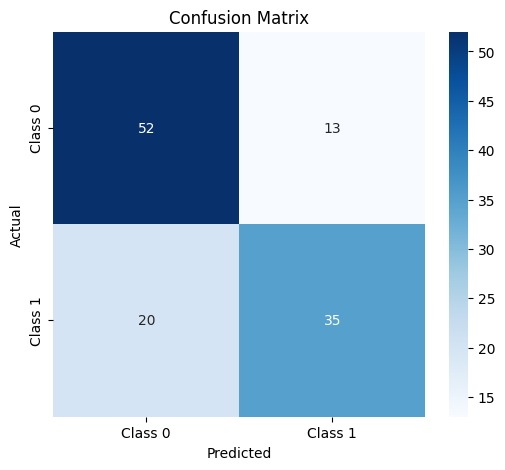

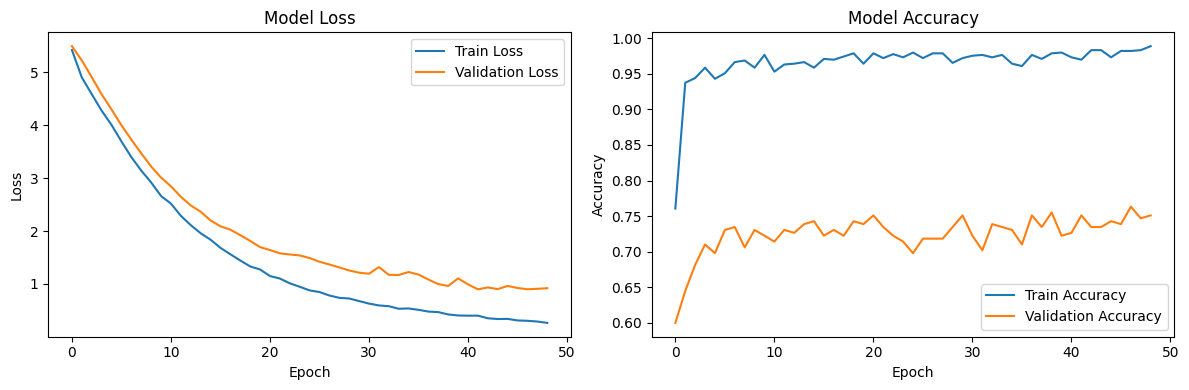

In [34]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot CM
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Loss and Accuracy Plots
plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
model.save("Jaundice_Classifier_kmeans1.keras") 